In [1]:
import ROOT
from ROOT import TFile
from ROOT import RooDataSet, RooDataHist, RooArgSet, RooArgList, RooRealVar, RooFormulaVar, RooWorkspace
from ROOT import RooBDecay, RooTruthModel, RooFFTConvPdf, RooHistPdf, RooDecay
from ROOT import gPad , TCanvas , TPaveText , TLegend
from ROOT import RooFit, RooRealVar, RooGaussian, RooDataHist, RooAddPdf

In [2]:
import uproot
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mplhep as hep
import zfit

/opt/anaconda3/envs/root-env/lib/python3.12/site-packages/zfit/__init__.py:60: UserWarning: TensorFlow warnings are by default suppressed by zfit. In order to show them, set the environment variable ZFIT_DISABLE_TF_WARNINGS=0. In order to suppress the TensorFlow warnings AND this warning, set ZFIT_DISABLE_TF_WARNINGS=1.
  warnings.warn(


In [3]:
pd.set_option('display.max_columns', None)  # show all column

In [4]:
prompt_up = ROOT.TFile.Open("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000001_1.data24.root")
# data24_prompt_withut_magup
prompt_down = ROOT.TFile.Open("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000001_1.data24.root")
# data24_prompt_withut_magdown

mcprompt_up = ROOT.TFile.Open("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00237601/0000/00237601_00000001_1.mc.root")
# mc24_magup_prompt_bstojpsiphi_13144011_hlt1,2,
mcprompt_down = ROOT.TFile.Open("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00237610/0000/00237610_00000001_1.mc.root")
# mc24_magdown_prompt_bstojpsiphi_13144011_hlt1,2,

mcdata_up = ROOT.TFile.Open("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00237559/0000/00237559_00000001_1.mc.root")
# mc24_magup_bstojpsiphi_13144011_hlt1,2,
mcdata_down = ROOT.TFile.Open("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00237560/0000/00237560_00000001_1.mc.root")
# mc24_magdown_bstojpsiphi_13144011_hlt1,2,

In [5]:
mcprompt_down.ls()

TNetXNGFile**		root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00237610/0000/00237610_00000001_1.mc.root	
 TNetXNGFile*		root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/MC/2024/MC.ROOT/00237610/0000/00237610_00000001_1.mc.root	
  KEY: TDirectoryFile	BsToJpsiPhi_MC;1	BsToJpsiPhi_MC
  KEY: TDirectoryFile	BsToJpsiPhi;1	BsToJpsiPhi


# Function

In [6]:
def data_extraction_root_to_pd (data_paths,braches,tree_path):
    """
    example: 
    prompt_paths = [
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000001_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000001_1.data24.root"
    ]
    
    braches=["Bs_DTF_PV_CTAU", "Bs_DTF_PV_CTAUERR","RUNNUMBER"]
    
    tree_path = "BsToJpsiPhi/DecayTree"
    """
    all_data = []

    for path in data_paths:
        with uproot.open(path) as file:
            tree = file[tree_path] 
    
            branches = tree.arrays(
                braches,
                library="pd"
            )
    
            all_data.append(branches)

    combined_df = pd.concat(all_data, ignore_index=True)
    return combined_df

In [7]:
def quantiles_cutting_cal(selected_condition_quantity, filtered_quantity, quantiles, combined_df,cut_on_condata,
                          cut_on_quantity,unit=None,fitting_plots=False, cutting_binplot=False, mu_mean=None
                          ):
    """
    First limit the data (x-axis) according to cut_neg_x,cut_pos_x, then “cut”/select according to the established quantile.
    Fitting each cut plot


    Returns:
    dict:  fitting_results
    """
    
    fitting_results = {
        "quantile_range": [],
        "mean": [],
        "mean_error": [],
        "sigma": [],
        "sigma_error": [],
        "sigma_width_bar": [],
        "mid_bin_point": []
    }
######################### Fitting ######################### 
    for i in range(len(quantiles) - 1):
        # Data processing
        cut_df = combined_df[
            (combined_df[selected_condition_quantity] > quantiles[i]) & 
            (combined_df[selected_condition_quantity] < quantiles[i + 1])
        ]
        Ctau_data = cut_df[filtered_quantity]
        Ctau_data_filtered = Ctau_data[(Ctau_data >= cut_on_quantity[0]) & (Ctau_data <= cut_on_quantity[1])]

        # to zfit
        obs = zfit.Space(filtered_quantity, limits=(cut_on_quantity[0], cut_on_quantity[1]))
        Ctau_data_zfit = zfit.Data.from_numpy(obs=obs, array=Ctau_data_filtered.values)

        # Gauss
        mean = zfit.Parameter(f"mean_{i}", cut_on_quantity[1]/2, cut_on_quantity[0], cut_on_quantity[1])
        sigma = zfit.Parameter(f"sigma_{i}", cut_on_quantity[1]/2, 0, cut_on_quantity[1])
        amplitude = zfit.Parameter(f"amplitude_{i}", 1, 0, 10)
        gauss = zfit.pdf.Gauss(obs=obs, mu=mean, sigma=sigma)
        if mu_mean is not None:
            mean = mu_mean
            gauss = zfit.pdf.Gauss(mu=mean, sigma=sigma, obs=obs)
        else:
            gauss = zfit.pdf.Gauss(mu=mean, sigma=sigma, obs=obs)

        # Loss function and minimizer
        nll = zfit.loss.UnbinnedNLL(model=gauss, data=Ctau_data_zfit)
        minimizer = zfit.minimize.Minuit()

        # Fitting
        result = minimizer.minimize(nll)
        errors = result.hesse()
        
######################### Fitting parameters ######################### 
        # Save fitting parameters
        if result.converged:
            # Extract fitted parameter values
            sigma_val = sigma.value().numpy()
            if mu_mean is not None:
                mean_val = mean
            else:
                mean_val = mean.value().numpy()

            # Extract error bars using the Hesse method
            errors = result.hesse()
            if mu_mean is not None:
                mean_error = 0
            else:
                mean_error = errors[mean]['error']
            sigma_error = errors[sigma]['error']

            # Append results to the dictionary
            fitting_results["quantile_range"].append((quantiles[i], quantiles[i + 1]))
            fitting_results["mean"].append(mean_val)
            fitting_results["mean_error"].append(mean_error)
            fitting_results["sigma"].append(sigma_val)
            fitting_results["sigma_error"].append(sigma_error)
            fitting_results["sigma_width_bar"].append((quantiles[i+1] - quantiles[i]) / 2)
            fitting_results["mid_bin_point"].append(quantiles[i] + (quantiles[i+1] - quantiles[i]) / 2)
        else:
            # Append None values for failed fits
            fitting_results["quantile_range"].append((quantiles[i], quantiles[i + 1]))
            fitting_results["mean"].append(None)
            fitting_results["mean_error"].append(None)
            fitting_results["sigma"].append(None)
            fitting_results["sigma_error"].append(None)
            fitting_results["sigma_width_bar"].append(None)
            fitting_results["mid_bin_point"].append(None)

#######################################################################
        # Plot
        x_plot = np.linspace(cut_on_quantity[0], cut_on_quantity[1], 1000)
        y_plot = zfit.run(gauss.pdf(x_plot, norm_range=obs))
        
        if fitting_plots is not False:
            plt.figure(figsize=(10, 6))
            plt.hist(Ctau_data_filtered, bins=300, range=(cut_on_quantity[0]*1.3, cut_on_quantity[1]*1.3), density=True, color='blue', alpha=0.3, label='Data')
            plt.plot(x_plot, y_plot, color='red', lw=2, label=f'Fit for quantile {quantiles[i]:.5f}-{quantiles[i + 1]:.5f}')
            plt.title(f"{filtered_quantity} for quantile {quantiles[i]:.5f}-{quantiles[i + 1]:.5f}")
            plt.xlabel(filtered_quantity)
            plt.ylabel("Count")
            plt.legend()
            plt.grid(True)
            plt.show()
######################### colourfull histogram ######################### 
    data = combined_df[selected_condition_quantity].values
    binned_data = []

    # go through all quantile，and extract wanted range of filtered_quantity
    for i in range(len(quantiles) - 1):
        cut_df = combined_df[(combined_df[selected_condition_quantity] > quantiles[i]) & (combined_df[selected_condition_quantity] <= quantiles[i + 1])]
        Ctau_data = cut_df[selected_condition_quantity].values
        binned_data.append(Ctau_data)
#        print(f"Bin {i+1} ({quantiles[i]:.5f} to {quantiles[i+1]:.5f}) contains {len(Ctau_data)} data points.")

    plt.figure(figsize=(10, 6))

    if cutting_binplot is not False:
        for i in range(len(binned_data)):
            plt.hist(binned_data[i], bins=1000, alpha=0.5, range=(cut_on_condata[0]*0.8, cut_on_condata[1]*1.2), label=f'Quantile {i+1}: {quantiles[i]:.5f} - {quantiles[i+1]:.5f}')

        if unit is not None:
            plt.xlabel(f"{selected_condition_quantity}, {'('}{unit}{')'}")
        else:
            plt.xlabel(selected_condition_quantity)
        plt.ylabel('Counts')
        plt.legend()
        plt.show()   
     

    return fitting_results

In [8]:
def gaussfit_without_BG (fitting_quantity, combined_df,cut_on_data,plot=False,mean=None,zfit_spc_lim = None, sw=None ):
    # data Bs_BPVLTIME in [-0.0001, 0.0001]
    data = combined_df[(combined_df[fitting_quantity] >= cut_on_data[0]) & (combined_df[fitting_quantity] <= cut_on_data[1])]  
    data_np = data[fitting_quantity].values

    # define zfit space 
    if zfit_spc_lim is not None:
        obs = zfit.Space(fitting_quantity, limits=(zfit_spc_lim[0], zfit_spc_lim[1]))
    else:
        obs = zfit.Space(fitting_quantity, limits=(cut_on_data[0], cut_on_data[1]))
    

    # load data zfit
    if sw is not None:
        weights_np = data[sw].values
        data = zfit.Data.from_numpy(obs=obs, array=data_np, weights=weights_np)
    else:
        data = zfit.Data.from_numpy(obs=obs, array=data_np)

    # gaussian
    
        
    sigma = zfit.Parameter("sigma", 0.01, 0, abs(cut_on_data[1]))
    if mean is not None:
        if len(mean) == 1:
            mu = mean
        else:
            mu =  zfit.Parameter("mean", 0.0, mean[0], mean[1])
    else:
        mu = zfit.Parameter("mean", 0.0, cut_on_data[0], cut_on_data[1])
    
    gauss = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
  

    # combined model
    model = gauss

    # fitting
    nll = zfit.loss.UnbinnedNLL(model=model, data=data)
    minimizer = zfit.minimize.Minuit()
    result = minimizer.minimize(nll)

    # plot
    x_plot = np.linspace(cut_on_data[0], cut_on_data[1], 1000)
    y_plot = zfit.run(model.pdf(x_plot, norm_range=obs))

    # plot
    if plot is not False:  
        plt.figure(figsize=(10, 6))
        plt.hist(data_np, bins=300, range=(cut_on_data[0], cut_on_data[1]), density=True, color='blue', alpha=0.3, label='Data')
        plt.plot(x_plot, y_plot, color='red', lw=2, label='Fit')
        plt.xlabel(fitting_quantity)
        plt.ylabel("Count")
        plt.legend()
        plt.grid(True)
        plt.show()

 
    result.hesse()  
    fitting_param = result.params
    
    return  fitting_param, len(data_np)

In [9]:
def quantiles_cutting_data (selected_condition_quantity, filtered_quantity, combined_df, quantiles,
                            cut_on_condata,cut_on_quantity, nbin, color_plots=False):
    """
    cut on Ctauerr and getting data
    cut_on_condata nologer works here, you need to trim data outside the code.

    Returns:
    dict:  cutting_results
    """
    
    cutting_results = {
        'cut_data':[],
        "quantile_range": [],
        "width_bar": [],
        "mid_bin_point": [],
        "average_point": []
    }
######################### Fitting ######################### 
    for i in range(len(quantiles) - 1):
        # Data processing

        
        cut_df = combined_df[
            (combined_df[selected_condition_quantity] > quantiles[i]) & 
            (combined_df[selected_condition_quantity] <= quantiles[i + 1])
        ]
        cut_data = cut_df[filtered_quantity]
        cut_data_filtered = cut_data[(cut_data >= cut_on_quantity[0]) & (cut_data <= cut_on_quantity[1])]
        
######################### Cutting parameters ######################### 

        # Append results to the dictionary
        cutting_results["cut_data"].append(cut_data_filtered)
        cutting_results["quantile_range"].append((quantiles[i], quantiles[i + 1]))
        cutting_results["width_bar"].append((quantiles[i+1] - quantiles[i]) / 2)
        cutting_results["mid_bin_point"].append(quantiles[i] + (quantiles[i+1] - quantiles[i]) / 2)
        cutting_results["average_point"].append(np.average(np.array(cut_df[selected_condition_quantity])))

######################### colourfull histogram ######################### 
    data = combined_df[selected_condition_quantity].values
    binned_data = []

    # go through all quantile，and extract wanted range of filtered_quantity
    for i in range(len(quantiles) - 1):
        cut_df = combined_df[(combined_df[selected_condition_quantity] > quantiles[i]) & (combined_df[selected_condition_quantity] <= quantiles[i + 1])]
        Ctau_data = cut_df[selected_condition_quantity].values
        binned_data.append(Ctau_data)
   #     print(f"Bin {i+1} ({quantiles[i]:.5f} to {quantiles[i+1]:.5f}) contains {len(Ctau_data)} data points.")

   

    if color_plots is not False:
        
        plt.figure(figsize=(10, 6))
    
        for i in range(len(binned_data)):
         #   plt.hist(binned_data[i], bins=1000, alpha=0.5,  label=f'Quantile {i+1}: {quantiles[i]:.5f} - {quantiles[i+1]:.5f}')
            plt.hist(binned_data[i], bins=nbin, range=(cut_on_condata[0]*0.8, cut_on_condata[1]*1.2), alpha=0.5)

        plt.xlabel(selected_condition_quantity)
        plt.ylabel('Counts')
#        plt.legend()
        plt.show() 
        

    return cutting_results

# Prompt Data

### Ctau

In [10]:
prompt_paths = [
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000001_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000002_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000005_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000006_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000003_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000004_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000010_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000007_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000009_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000011_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000008_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000021_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000020_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000016_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000015_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000012_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000001_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000002_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000004_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000003_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000005_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000006_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000007_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000010_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000009_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000008_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000011_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000012_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000013_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000014_1.data24.root",
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000015_1.data24.root"
]


In [11]:
prompt_paths = [
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000001_1.data24.root"
]
braches=["Bs_DTF_PV_CTAU", "Bs_DTF_PV_CTAUERR","RUNNUMBER","NPVs","Jpsi_M","Bs_ETA","Bs_PT",'Bs_PX',
         'Bs_PY','Bs_PZ','Bs_BPVIPCHI2','Bs_BPVIP',
         "Bs_BPVZ","Bs_BPVX","Bs_BPVY","Bs_END_VX","Bs_END_VY","Bs_END_VZ"]
tree_path = "BsToJpsiPhi/DecayTree"


combined_df_prompt = data_extraction_root_to_pd(prompt_paths,braches,tree_path)

In [12]:
prompt_paths = [
    "root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000001_1.data24.root"
]
braches=["ALLPVX", "ALLPVY","ALLPVZ",'Bs_PX','Bs_PY','Bs_PZ','Bs_BPVIP',
         "Bs_BPVZ","Bs_BPVX","Bs_BPVY","Bs_END_VX","Bs_END_VY","Bs_END_VZ"]
tree_path = "BsToJpsiPhi/DecayTree"

IP_df_prompt = data_extraction_root_to_pd(prompt_paths,braches,tree_path)

In [13]:
combined_df_prompt['Bs_DTF_PV_TAUERR (ps)'] =combined_df_prompt['Bs_DTF_PV_CTAUERR']/0.3
combined_df_prompt['Bs_DTF_PV_TAU (ps)'] =combined_df_prompt['Bs_DTF_PV_CTAU']/0.3
combined_df_prompt['Cot_theta'] = combined_df_prompt['Bs_PZ']/combined_df_prompt['Bs_PT']

In [14]:
combined_prompt  = ROOT.TChain("BsToJpsiPhi/DecayTree")  
for path in prompt_paths:
    combined_prompt.Add(path)

In [15]:
branch_list = combined_prompt.GetListOfBranches()

for branch in branch_list:
    print(branch.GetName())

NPVs
ALLPVX
ALLPVY
ALLPVZ
BUNCHCROSSING_ID
BUNCHCROSSING_TYPE
EVENTNUMBER
GPSTIME
Hlt1D2KKDecision
Hlt1D2KPiDecision
Hlt1D2PiPiDecision
Hlt1DiMuonHighMassDecision
Hlt1DiMuonLowMassDecision
Hlt1DiMuonNoIPDecision
Hlt1DiMuonNoIP_ssDecision
Hlt1DiMuonSoftDecision
Hlt1DisplacedDiMuonDecision
Hlt1DisplacedLeptonsDecision
Hlt1GECPassthroughDecision
Hlt1KsToPiPiDecision
Hlt1LowPtDiMuonDecision
Hlt1LowPtMuonDecision
Hlt1OneMuonDecision
Hlt1OneMuonTrackLineDecision
Hlt1PassthroughDecision
Hlt1SingleHighEtDecision
Hlt1SingleHighPtMuonDecision
Hlt1TrackMVADecision
Hlt1TrackMuonMVADecision
Hlt1TwoTrackKsDecision
Hlt1TwoTrackMVACharmXSecDecision
Hlt1TwoTrackMVADecision
Hlt1_TCK
Hlt2B2CC_BdToJpsiKstar_JpsiToMuMu_DetachedDecision
Hlt2B2CC_BsToJpsiPhiDecision
Hlt2B2CC_BsToJpsiPhi_DetachedDecision
Hlt2B2CC_BsToJpsiPhi_ExtraMuonDecision
Hlt2B2CC_BsToJpsiPhi_JpsiToEE_DetachedDecision
Hlt2B2CC_BuToJpsiKplus_JpsiToMuMu_DetachedDecision
Hlt2B2OC_BdToDsmPi_DsmToKpKmPimDecision
Hlt2_TCK
NLongTracks
NPV
ODINTC

## Sweight

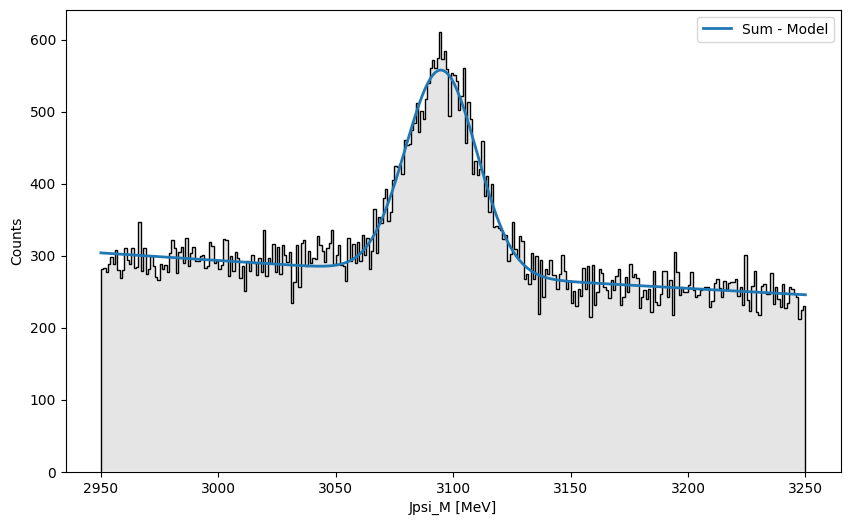

In [16]:
import zfit
from zfit import z
import numpy as np
import matplotlib.pyplot as plt
from hepstats.splot import compute_sweights

data_np = combined_df_prompt["Jpsi_M"].values

# Define the space
obs = zfit.Space("Jpsi_M", limits=(data_np.min(), data_np.max()))

# Load data
data = zfit.Data.from_numpy(obs=obs, array=data_np)

# Define Gaussian signal
mean = zfit.Parameter("mean", 3090, 3050, 3150)
sigma = zfit.Parameter("sigma", 10, 0.01, 80)
gauss = zfit.pdf.Gauss(mu=mean, sigma=sigma, obs=obs)
nsig = zfit.Parameter("nsig", 5000, 0,3000000)
signal_pdf = gauss.create_extended(nsig)

# Define exponential background
lambda_exp = zfit.Parameter("lambda", -1.0, -10.0, 0)
expo = zfit.pdf.Exponential(lam=lambda_exp, obs=obs)
nbkg = zfit.Parameter("nbkg", 50000, 0, 3000000)
background_pdf = expo.create_extended(nbkg)

# Combined model
model = zfit.pdf.SumPDF([signal_pdf, background_pdf])

# Fit the model
nll = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data)
minimizer = zfit.minimize.Minuit()
result = minimizer.minimize(nll)
result.hesse()

# Plotting
n_bins = 300
plot_scaling = len(data_np) / n_bins * obs.area()
x_plot = np.linspace(data_np.min(), data_np.max(), 1000)
y_plot = model.pdf(x_plot).numpy() * plot_scaling

plt.figure(figsize=(10, 6))
plt.hist(data_np, bins=n_bins, color='black', histtype="stepfilled", alpha=0.1)
plt.hist(data_np, bins=n_bins, color='black', histtype="step")
plt.plot(x_plot, y_plot, label="Sum - Model", linewidth=2)
plt.xlabel("Jpsi_M [MeV]")
plt.ylabel("Counts")
plt.legend()
plt.show()


In [17]:
# Compute sWeights
sweights = compute_sweights(model, data_np)
sweights_signal = sweights[nsig]
sweights_background = sweights[nbkg]

data_dict = {
    'nsig_weights':sweights_signal,
    'nbkg_weights': sweights_background
}
df = pd.DataFrame(data_dict)

In [18]:
combined_df_prompt['nsig_weights'] = df['nsig_weights']
combined_df_prompt['nbkg_weights'] = df['nbkg_weights']

In [19]:
combined_df_prompt = combined_df_prompt[(combined_df_prompt['Bs_BPVIPCHI2'] <= 30)]

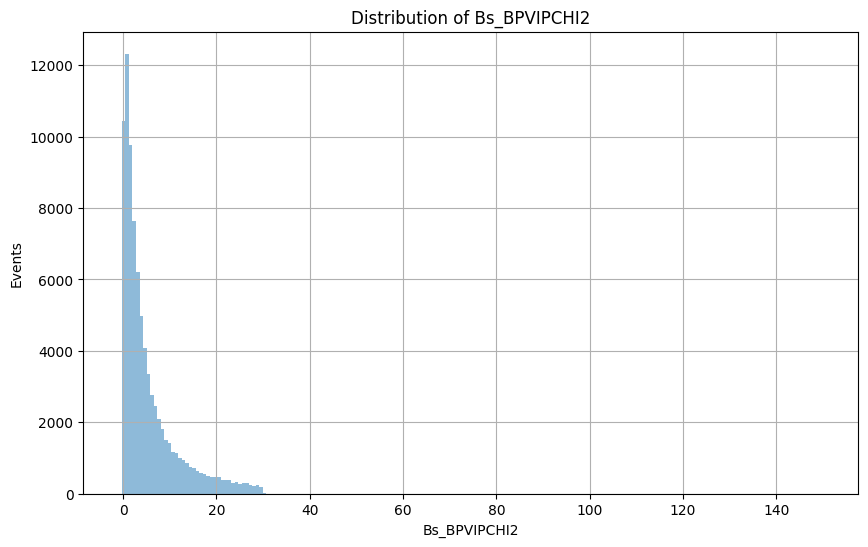

In [20]:
# BPVIPCHI2
plt.figure(figsize=(10, 6))
plt.hist(combined_df_prompt['Bs_BPVIPCHI2'], bins=200, range=(-1,150), alpha=0.5)
plt.title("Distribution of Bs_BPVIPCHI2")
plt.xlabel('Bs_BPVIPCHI2')
plt.ylabel('Events')
plt.grid(True)
plt.show()

In [21]:
combined_df_prompt

,Bs_DTF_PV_CTAU,Bs_DTF_PV_CTAUERR,RUNNUMBER,NPVs,Jpsi_M,Bs_ETA,Bs_PT,Bs_PX,Bs_PY,Bs_PZ,Bs_BPVIPCHI2,Bs_BPVIP,Bs_BPVZ,Bs_BPVX,Bs_BPVY,Bs_END_VX,Bs_END_VY,Bs_END_VZ,Bs_DTF_PV_TAUERR (ps),Bs_DTF_PV_TAU (ps),Cot_theta,nsig_weights,nbkg_weights
0,0.002657,0.006551,301189,5,3061.531982,5.846637,736.577271,-163.199997,718.270020,127453.296875,10.141629,0.047100,143.832306,0.4722,0.0677,0.5137,0.0456,143.854095,0.021835,0.008856,173.034531,0.016404,0.983602
1,0.030953,0.007928,301189,4,2978.024902,3.817983,4106.308105,3190.750000,-2584.739990,93398.250000,1.532001,0.016316,-8.523900,0.4709,0.0079,0.4893,-0.0235,-7.979000,0.026426,0.103176,22.745066,-0.242977,1.242986
2,0.010263,0.008952,301189,8,3085.274902,4.276106,2117.672852,-167.600006,-2111.030029,76185.906250,2.671608,0.021399,13.629600,0.4424,0.0252,0.4459,0.0453,13.665900,0.029838,0.034210,35.976238,1.166546,-0.166560
3,0.015013,0.008482,301189,4,3068.941162,5.120895,653.502136,-549.419983,-353.839996,54724.929688,5.795033,0.041605,-42.151402,0.4293,0.0168,0.3853,0.0219,-41.853500,0.028273,0.050044,83.741013,0.349734,0.650266
4,0.011542,0.008284,301189,4,3068.941162,5.125237,650.532593,-551.369995,-345.230011,54713.031250,6.695728,0.037354,-42.151402,0.4293,0.0168,0.3940,-0.0014,-41.952301,0.027612,0.038473,84.104980,0.349734,0.650266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92895,-0.020308,0.009935,300537,9,3094.687012,4.232072,3011.084961,-2154.169922,2103.850098,103658.640625,5.559125,0.034816,-92.795403,0.4202,0.0721,0.4646,0.0479,-93.368797,0.033116,-0.067692,34.425678,1.325252,-0.325267
92896,0.022605,0.014744,300537,6,3052.850830,3.597981,3123.189941,1959.239990,-2432.219971,56998.968750,0.593336,0.012721,4.676900,0.4075,0.0794,0.4271,0.0732,4.885300,0.049147,0.075350,18.250240,-0.175760,1.175769
92897,0.024543,0.011702,300537,8,2980.644287,3.743231,3975.906006,-739.070007,3906.610107,83913.671875,12.082598,0.041219,45.539200,0.4000,0.0753,0.4005,0.1357,45.954800,0.039007,0.081809,21.105547,-0.242977,1.242986
92898,-1.250537,0.014493,300537,7,3098.511475,4.269011,2607.546875,2523.790039,-655.580017,93146.640625,0.826139,0.022550,78.355904,0.3992,0.0825,0.3647,0.0822,77.905197,0.048311,-4.168458,35.721943,1.305810,-0.305826


----

In [22]:
fitting_params_Generalprompt,_ = gaussfit_without_BG('Bs_DTF_PV_TAU (ps)',combined_df_prompt,[-0.1,0.1],plot=False)
# fitting_quantity, combined_df,cut_on_data,plot=False):
cut_df_c = combined_df_prompt[(combined_df_prompt['Bs_DTF_PV_TAU (ps)'] <= fitting_params_Generalprompt['mean']['value'])]

In [23]:
cut_df_c.loc[:, 'shifted_Bs_DTF_PV_TAU (ps)'] = cut_df_c['Bs_DTF_PV_TAU (ps)'] - fitting_params_Generalprompt['mean']['value']

/var/folders/lg/sm4b58wn6gn_45ytw5wczs8h0000gn/T/ipykernel_91444/2395567038.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cut_df_c.loc[:, 'shifted_Bs_DTF_PV_TAU (ps)'] = cut_df_c['Bs_DTF_PV_TAU (ps)'] - fitting_params_Generalprompt['mean']['value']


In [24]:
cut_df_c

,Bs_DTF_PV_CTAU,Bs_DTF_PV_CTAUERR,RUNNUMBER,NPVs,Jpsi_M,Bs_ETA,Bs_PT,Bs_PX,Bs_PY,Bs_PZ,Bs_BPVIPCHI2,Bs_BPVIP,Bs_BPVZ,Bs_BPVX,Bs_BPVY,Bs_END_VX,Bs_END_VY,Bs_END_VZ,Bs_DTF_PV_TAUERR (ps),Bs_DTF_PV_TAU (ps),Cot_theta,nsig_weights,nbkg_weights,shifted_Bs_DTF_PV_TAU (ps)
5,-0.003948,0.006459,301189,6,3037.475342,6.445494,373.225189,248.419998,-278.540009,117545.937500,5.076900,0.030890,-62.679298,0.4630,0.0419,0.4808,0.0672,-62.741001,0.021529,-0.013161,314.946411,-0.240456,1.240466,-0.011573
6,-0.004624,0.006327,301189,6,3037.475342,5.576809,932.344116,-198.630005,-910.940002,123180.351562,3.771078,0.026764,-62.679298,0.4630,0.0419,0.4772,0.0651,-62.740299,0.021089,-0.015412,132.118973,-0.240456,1.240466,-0.013824
9,-0.002409,0.010504,301189,10,3072.742920,3.709818,3649.878662,-1950.199951,-3085.179932,74500.203125,0.682229,0.010566,-103.805199,0.4474,0.0234,0.4375,0.0190,-103.798798,0.035012,-0.008029,20.411694,0.562918,0.437079,-0.006441
14,-0.021154,0.012811,301189,5,3140.211914,4.149810,1787.640259,-1638.140015,715.650024,56675.101562,1.245290,0.015524,47.093399,0.4477,0.0464,0.4574,0.0276,46.824600,0.042705,-0.070512,31.703863,-0.203852,1.203860,-0.068925
16,-0.006187,0.010554,301189,4,3092.863770,4.309137,2404.643311,-1125.150024,2125.169922,89415.367188,1.725939,0.015051,37.981098,0.4639,0.0393,0.4706,0.0504,37.851799,0.035181,-0.020623,37.184464,1.317423,-0.317439,-0.019036
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92889,-0.002252,0.009480,300537,7,3134.323975,3.347433,3179.305420,-1487.579956,2809.820068,45141.539062,0.892728,0.010412,9.357200,0.3875,0.0834,0.3984,0.0784,9.327800,0.031600,-0.007507,14.198554,-0.131604,1.131612,-0.005919
92890,-0.084956,0.011632,300537,11,3134.005371,3.765839,2083.534668,651.580017,-1979.030029,44980.511719,19.637766,0.064364,22.012100,0.3959,0.0693,0.3836,0.0253,21.553600,0.038773,-0.283186,21.588560,-0.125699,1.125707,-0.281599
92892,-0.031883,0.009861,300537,6,3060.891846,4.998536,910.678894,-873.710022,256.839996,67482.500000,13.329475,0.059182,-43.464802,0.4179,0.0512,0.4839,0.0572,-44.034801,0.032869,-0.106277,74.101311,-0.004928,1.004934,-0.104689
92895,-0.020308,0.009935,300537,9,3094.687012,4.232072,3011.084961,-2154.169922,2103.850098,103658.640625,5.559125,0.034816,-92.795403,0.4202,0.0721,0.4646,0.0479,-93.368797,0.033116,-0.067692,34.425678,1.325252,-0.325267,-0.066104


0.4722

## Event mixing 
### Picking close PV, base on,
$$ \Delta x = x_{PV}-x_{SV} + (z_{SV} - z_{PV})*\frac{P_x}{P_z} = IP_x $$
$$ \Delta y = y_{PV}-y_{SV} + (z_{SV} - z_{PV})*\frac{P_y}{P_z} = IP_y $$
$$ IP^2 = \frac{\Delta x^2 + \Delta y^2}{\sqrt{1+t^2_x+t_y^2}} $$
where $t_x = \frac{P_x}{P_z}, t_y = \frac{P_y}{P_z}$

In [97]:
Delta_x = IP_df_prompt['Bs_BPVX'] - IP_df_prompt['Bs_END_VX'] + (IP_df_prompt['Bs_END_VZ'] \
                                                         -  IP_df_prompt['Bs_BPVZ'])*(IP_df_prompt['Bs_PX']/IP_df_prompt['Bs_PZ'])
Delta_y = IP_df_prompt['Bs_BPVY'] - IP_df_prompt['Bs_END_VY'] + (IP_df_prompt['Bs_END_VZ'] \
                                                         -  IP_df_prompt['Bs_BPVZ'])*(IP_df_prompt['Bs_PY']/IP_df_prompt['Bs_PZ'])

In [99]:
IP_2 = (Delta_x**2 + Delta_x**2) / np.sqrt( 1 + (IP_df_prompt['Bs_PY']/IP_df_prompt['Bs_PZ'])**2 \
                                           + (IP_df_prompt['Bs_PX']/IP_df_prompt['Bs_PZ'])**2 )

In [102]:
IP_df_prompt.loc[:, 'IP_2'] = IP_2
IP_df_prompt.loc[:, 'Cal_IP'] = np.sqrt(IP_2)

In [104]:
print(IP_df_prompt[['Bs_BPVIP','Bs_BPVZ', 'IP_2','Cal_IP']])

       Bs_BPVIP     Bs_BPVZ          IP_2    Cal_IP
0      0.047100  143.832306  3.449076e-03  0.058729
1      0.016316   -8.523900  9.263584e-08  0.000304
2      0.021399   13.629600  2.562064e-05  0.005062
3      0.041605  -42.151402  3.363265e-03  0.057994
4      0.037354  -42.151402  2.216769e-03  0.047083
...         ...         ...           ...       ...
92895  0.034816  -92.795403  2.109540e-03  0.045930
92896  0.012721    4.676900  3.088752e-04  0.017575
92897  0.041219   45.539200  3.457890e-05  0.005880
92898  0.022550   78.355904  9.931386e-04  0.031514
92899  0.017073    2.804700  5.821727e-04  0.024128

[92900 rows x 4 columns]


### ALLPV

In [120]:
h = 1
Delta_x_sgl = IP_df_prompt['Bs_BPVX'][h] - IP_df_prompt['Bs_END_VX'][h] + (IP_df_prompt['Bs_END_VZ'][h] \
                                                         -  IP_df_prompt['Bs_BPVZ'][h])*(IP_df_prompt['Bs_PX'][h]/IP_df_prompt['Bs_PZ'][h])
Delta_y_sgl = IP_df_prompt['Bs_BPVY'][h] - IP_df_prompt['Bs_END_VY'][h] + (IP_df_prompt['Bs_END_VZ'][h] \
                                                         -  IP_df_prompt['Bs_BPVZ'][h])*(IP_df_prompt['Bs_PY'][h]/IP_df_prompt['Bs_PZ'][h])
IP_2_sgl = ( Delta_x_sgl**2 + Delta_x_sgl**2 ) / np.sqrt( 1 + (IP_df_prompt['Bs_PX'][h]/IP_df_prompt['Bs_PZ'][h])**2 \
                                             + (IP_df_prompt['Bs_PY'][h]/IP_df_prompt['Bs_PZ'][h])**2 )

In [121]:
Delta_x_ls = IP_df_prompt['ALLPVX'][h] - IP_df_prompt['Bs_END_VX'][h] + (IP_df_prompt['Bs_END_VZ'][h] \
                                                         -  IP_df_prompt['ALLPVZ'][h])*(IP_df_prompt['Bs_PX'][h]/IP_df_prompt['Bs_PZ'][h])
Delta_y_ls = IP_df_prompt['ALLPVY'][h] - IP_df_prompt['Bs_END_VY'][h] + (IP_df_prompt['Bs_END_VZ'][h] \
                                                         -  IP_df_prompt['ALLPVZ'][h])*(IP_df_prompt['Bs_PY'][h]/IP_df_prompt['Bs_PZ'][h])
IP_2_ls = ( Delta_x_ls**2 + Delta_x_ls**2 ) / np.sqrt( 1 + (IP_df_prompt['Bs_PX'][h]/IP_df_prompt['Bs_PZ'][h])**2 \
                                             + (IP_df_prompt['Bs_PY'][h]/IP_df_prompt['Bs_PZ'][h])**2 )

In [124]:
print('AllPV_IP:', np.sqrt(IP_2_ls))
print("Bs_BPVIP", IP_df_prompt['Bs_BPVIP'][h])
print('Cal_PV_IP',np.sqrt(IP_2_sgl)) 

AllPV_IP: [1.19, 0.000304, 1.71, 1.88]
Bs_BPVIP 0.016315605
Cal_PV_IP 0.0003043613722979731


In [125]:
print('ALLPV X',IP_df_prompt['ALLPVX'][h]) 
print('BPV X',IP_df_prompt['Bs_BPVX'][h]) 

ALLPV X [0.477, 0.471, 0.467, 0.444]
BPV X 0.4709


In [91]:
IP_df_prompt

,ALLPVX,ALLPVY,ALLPVZ,Bs_PX,Bs_PY,Bs_PZ,Bs_BPVIP,Bs_BPVZ,Bs_BPVX,Bs_BPVY,Bs_END_VX,Bs_END_VY,Bs_END_VZ
0,"[0.4237000048160553, 0.47699999809265137, 0.49...","[0.05270000174641609, 0.026799999177455902, 0....","[-12.40470027923584, 25.567699432373047, 34.07...",-163.199997,718.270020,127453.296875,0.047100,143.832306,0.4722,0.0677,0.5137,0.0456,143.854095
1,"[0.477400004863739, 0.4708999991416931, 0.4672...","[0.011500000022351742, 0.007899999618530273, 0...","[-33.0619010925293, -8.523900032043457, 26.762...",3190.750000,-2584.739990,93398.250000,0.016316,-8.523900,0.4709,0.0079,0.4893,-0.0235,-7.979000
2,"[0.43309998512268066, 0.3522000014781952, 0.47...","[-0.016599999740719795, 0.009399999864399433, ...","[-77.34619903564453, -61.42940139770508, 9.536...",-167.600006,-2111.030029,76185.906250,0.021399,13.629600,0.4424,0.0252,0.4459,0.0453,13.665900
3,"[0.4293000102043152, 0.4837999939918518, 0.458...","[0.01679999940097332, 0.003700000001117587, 0....","[-42.15140151977539, -8.318599700927734, 12.37...",-549.419983,-353.839996,54724.929688,0.041605,-42.151402,0.4293,0.0168,0.3853,0.0219,-41.853500
4,"[0.4293000102043152, 0.4837999939918518, 0.458...","[0.01679999940097332, 0.003700000001117587, 0....","[-42.15140151977539, -8.318599700927734, 12.37...",-551.369995,-345.230011,54713.031250,0.037354,-42.151402,0.4293,0.0168,0.3940,-0.0014,-41.952301
...,...,...,...,...,...,...,...,...,...,...,...,...,...
92895,"[0.420199990272522, 0.420199990272522, 0.40979...","[0.07209999859333038, 0.09390000253915787, 0.0...","[-92.79540252685547, -67.16570281982422, -63.1...",-2154.169922,2103.850098,103658.640625,0.034816,-92.795403,0.4202,0.0721,0.4646,0.0479,-93.368797
92896,"[0.4205999970436096, 0.40400001406669617, 0.41...","[0.04859999939799309, 0.05180000141263008, 0.1...","[-66.3104019165039, -42.735801696777344, -23.7...",1959.239990,-2432.219971,56998.968750,0.012721,4.676900,0.4075,0.0794,0.4271,0.0732,4.885300
92897,"[0.4036000072956085, 0.3693000078201294, 0.411...","[0.04450000077486038, 0.046799998730421066, 0....","[-32.04280090332031, -22.26259994506836, -15.4...",-739.070007,3906.610107,83913.671875,0.041219,45.539200,0.4000,0.0753,0.4005,0.1357,45.954800
92898,"[0.42879998683929443, 0.4036000072956085, 0.41...","[0.06480000168085098, 0.07750000059604645, 0.0...","[-44.1973991394043, -29.909900665283203, -12.0...",2523.790039,-655.580017,93146.640625,0.022550,78.355904,0.3992,0.0825,0.3647,0.0822,77.905197


# Gaussian plot

In [29]:
combined_prompt = ROOT.TChain("BsToJpsiPhi/DecayTree")  
combined_prompt.Add("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000001_1.data24.root")
combined_prompt.Add("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237612/0000/00237612_00000002_1.data24.root")
combined_prompt.Add("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000010_1.data24.root")
combined_prompt.Add("root://eoslhcb.cern.ch//eos/lhcb/grid/prod/lhcb/anaprod/lhcb/LHCb/Collision24/DATA24.ROOT/00237608/0000/00237608_00000009_1.data24.root")

1

In [30]:
branch_list = combined_prompt.GetListOfBranches()

for branch in branch_list:
    print(branch.GetName())

NPVs
ALLPVX
ALLPVY
ALLPVZ
BUNCHCROSSING_ID
BUNCHCROSSING_TYPE
EVENTNUMBER
GPSTIME
Hlt1D2KKDecision
Hlt1D2KPiDecision
Hlt1D2PiPiDecision
Hlt1DiMuonHighMassDecision
Hlt1DiMuonLowMassDecision
Hlt1DiMuonNoIPDecision
Hlt1DiMuonNoIP_ssDecision
Hlt1DiMuonSoftDecision
Hlt1DisplacedDiMuonDecision
Hlt1DisplacedLeptonsDecision
Hlt1GECPassthroughDecision
Hlt1KsToPiPiDecision
Hlt1LowPtDiMuonDecision
Hlt1LowPtMuonDecision
Hlt1OneMuonDecision
Hlt1OneMuonTrackLineDecision
Hlt1PassthroughDecision
Hlt1SingleHighEtDecision
Hlt1SingleHighPtMuonDecision
Hlt1TrackMVADecision
Hlt1TrackMuonMVADecision
Hlt1TwoTrackKsDecision
Hlt1TwoTrackMVACharmXSecDecision
Hlt1TwoTrackMVADecision
Hlt1_TCK
Hlt2B2CC_BdToJpsiKstar_JpsiToMuMu_DetachedDecision
Hlt2B2CC_BsToJpsiPhiDecision
Hlt2B2CC_BsToJpsiPhi_DetachedDecision
Hlt2B2CC_BsToJpsiPhi_ExtraMuonDecision
Hlt2B2CC_BsToJpsiPhi_JpsiToEE_DetachedDecision
Hlt2B2CC_BuToJpsiKplus_JpsiToMuMu_DetachedDecision
Hlt2B2OC_BdToDsmPi_DsmToKpKmPimDecision
Hlt2_TCK
NLongTracks
NPV
ODINTC

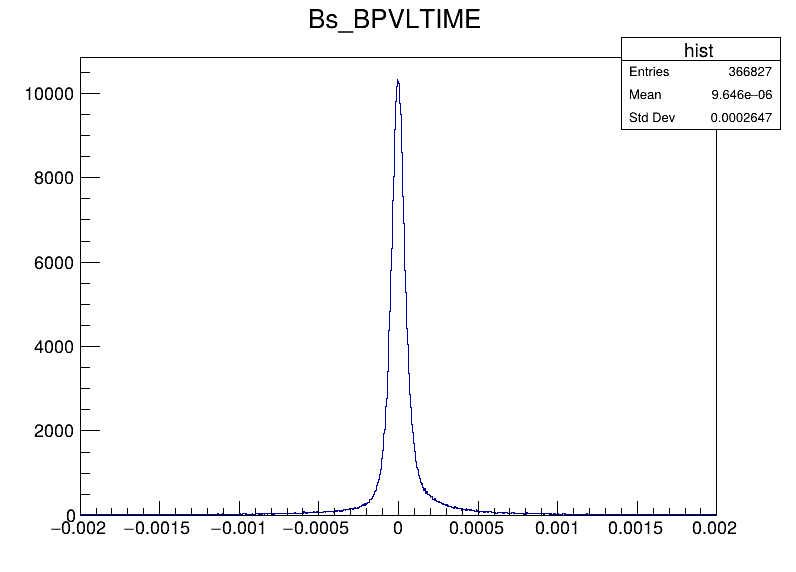

In [31]:
canvas_Bs= ROOT.TCanvas("canvas_Bs_BPVLTIME", "Bs Life TIME", 800, 600)
combined_prompt.Draw("Bs_BPVLTIME>>hist(1000,-0.002,0.002)");
canvas_Bs.Draw()

Warning in <TCanvas::Constructor>: Deleting canvas with same name: canvas_Bs_BPVLTIME


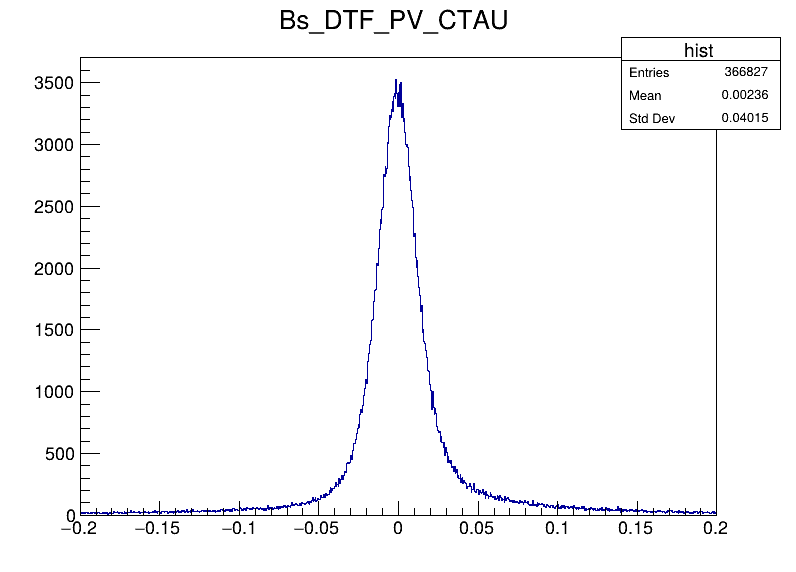

In [32]:
canvas_Bs_BPVLTIME = ROOT.TCanvas("canvas_Bs_BPVLTIME", "Bs Life TIME", 800, 600)
combined_prompt.Draw("Bs_DTF_PV_CTAU>>hist(1000,-0.2,0.2)")
canvas_Bs_BPVLTIME.Draw()


In [127]:
x = RooRealVar("x", "x", -0.2, 0.2)  
mean1 = RooRealVar("mean1", "Mean of Gaussian 1", 0, -0.1, 0.1)
sigma1 = RooRealVar("sigma1", "Width of Gaussian 1", 0.01, 0.001, 0.1)
gauss1 = RooGaussian("gauss1", "Gaussian 1", x, mean1, sigma1)

mean2 = RooRealVar("mean2", "Mean of Gaussian 2", 0, -0.1, 0.1)
sigma2 = RooRealVar("sigma2", "Width of Gaussian 2", 0.02, 0.001, 0.1)
gauss2 = RooGaussian("gauss2", "Gaussian 2", x, mean2, sigma2)

mean3 = RooRealVar("mean3", "Mean of Gaussian 3", 0, -0.1, 0.1)
sigma3 = RooRealVar("sigma3", "Width of Gaussian 3", 0.03, 0.001, 0.1)
gauss3 = RooGaussian("gauss3", "Gaussian 3", x, mean3, sigma3)

frac1 = RooRealVar("frac1", "Fraction of Gauss 1", 0.5, 0, 1)
frac2 = RooRealVar("frac2", "Fraction of Gauss 2", 0.3, 0, 1)

model = RooAddPdf("model", "Gaussian Mixture Model",
                  RooArgList(gauss1, gauss2, gauss3),
                  RooArgList(frac1, frac2))

h = ROOT.gDirectory.Get("hist")
data = RooDataHist("data", "dataset from hist", RooArgList(x), h)

model.fitTo(data, RooFit.Range(-0.2, 0.2))

frame = x.frame(RooFit.Title("Multi-Gaussian Fit to Histogram"))
data.plotOn(frame)
model.plotOn(frame)
model.plotOn(frame, RooFit.Components("gauss1"), RooFit.LineStyle(ROOT.kDashed), RooFit.LineColor(ROOT.kRed))
model.plotOn(frame, RooFit.Components("gauss2"), RooFit.LineStyle(ROOT.kDashed), RooFit.LineColor(ROOT.kGreen))
model.plotOn(frame, RooFit.Components("gauss3"), RooFit.LineStyle(ROOT.kDashed), RooFit.LineColor(ROOT.kBlue))

canvas = ROOT.TCanvas("canvas", "Multi-Gaussian Fit", 800, 600)
frame.Draw()
canvas.SetLogY()
canvas.Draw()


AttributeError: 'TCanvas' object has no attribute 'SetLogY'

[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'fit' created with bounds [-0.2,0.2]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'fit_nll_model_data' created with bounds [-0.2,0.2]
[#1] INFO:Fitting -- RooAbsPdf::fitTo(model) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model_data) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
Minuit2Minimizer: Minimize with max-calls 4000 convergence for edm < 1 strategy 1
Minuit2Minimizer : Valid minimum - status = 0
FVAL  = -743221.426608930109
Edm   = 0.000265568748719834493
Nfcn  = 456
frac1	  = 0.565511	 +/-  0.00628891	(limited)
frac2	  = 0.170664	 +/-  0.00113534	(limited)
mean1	  = -0.00103059	 +/-  4.05482e-05	(limited)
mean2	  = 0.015167	 +/-  0.000503327	(limited)
mean3	  = 0.00357737	 +/-  0.00019692	(limited)
sigma1	  = 0.01138

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -585931.6214 Edm =       89723.12636 NCalls =     43
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : -734198.5155
  Edm           : 13475.2003
  Internal parameters:	[                0    -0.4115168461                0                0                0    -0.9582415885     0.5295125979    -0.4269993197]	
  Internal gradient  :	[     -12254.07417      24360.46252      57235.02978      -13640.0172      -9591.66756     -34482.38289     -1709.690956      23719.26083]	
  Internal covariance matrix:
[[  1.8680994e-05              0              0              0              0              0              0              0]
 [              0  2.1581262e-05              0              0              0      

[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'fit' created with bounds [-0.2,0.2]
[#1] INFO:Eval -- RooRealVar::setRange(x) new range named 'fit_nll_model_data' created with bounds [-0.2,0.2]
[#1] INFO:Fitting -- RooAbsPdf::fitTo(model) fixing normalization set for coefficient determination to observables in data
[#1] INFO:Fitting -- RooAddition::defaultErrorLevel(nll_model_data) Summation contains a RooNLLVar, using its error level
[#1] INFO:Minimization -- RooAbsMinimizerFcn::setOptimizeConst: activating const optimization
Minuit2Minimizer: Minimize with max-calls 5500 convergence for edm < 1 strategy 1
[#0] WARNING:Eval -- RooAddPdf::updateCoefCache(model WARNING: sum of PDF coefficients not in range [0-1], value=1.14418
RooAbsMinimizerFcn: Minimized function has error status.
Returning maximum FCN so far (-561615) to force MIGRAD to back out of this region. Error log follows.
Parameter values: 	frac1=0.5	frac2=0.544184	frac3=0.1	mean1=0	mean2=0	mean3=0	mean4=0	sigma1=0

Info in <Minuit2>: MnSeedGenerator Computing seed using NumericalGradient calculator
Info in <Minuit2>: MnSeedGenerator Initial state: FCN =      -563208.1898 Edm =        108971.041 NCalls =     59
Info in <Minuit2>: NegativeG2LineSearch Doing a NegativeG2LineSearch since one of the G2 component is negative
Info in <Minuit2>: MnSeedGenerator Negative G2 found - new state: 
  Minimum value : -647165.4536
  Edm           : 125125.2788
  Internal parameters:	[                0    -0.4115168461     -0.927295218                0                0                0      1.381278102    -0.9582415885    -0.6638599611    -0.4269993197....     -0.6638599611]	
  Internal gradient  :	[     -58277.26432     -69013.98142     -90412.54913      49106.89754      144.9592675      148197.9721     -6860.357454       -35424.296     -56166.43562     -287555.4227....      -121630.1844]	
  Internal covariance matrix:
[[  3.5039105e-06              0              0              0              0              0  

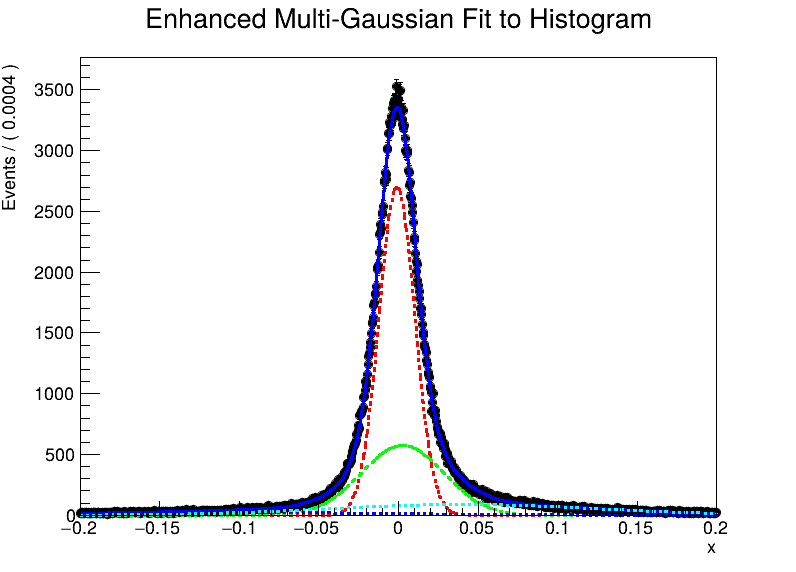

In [34]:
x = RooRealVar("x", "x", -0.2, 0.2)  
mean1 = RooRealVar("mean1", "Mean of Gaussian 1", 0, -0.1, 0.1) # (initial value, range_min, range_max)
sigma1 = RooRealVar("sigma1", "Width of Gaussian 1", 0.01, 0.001, 0.1)
gauss1 = RooGaussian("gauss1", "Gaussian 1", x, mean1, sigma1)

mean2 = RooRealVar("mean2", "Mean of Gaussian 2", 0, -0.1, 0.1)
sigma2 = RooRealVar("sigma2", "Width of Gaussian 2", 0.02, 0.001, 0.1)
gauss2 = RooGaussian("gauss2", "Gaussian 2", x, mean2, sigma2)

mean3 = RooRealVar("mean3", "Mean of Gaussian 3", 0, -0.1, 0.1)
sigma3 = RooRealVar("sigma3", "Width of Gaussian 3", 0.03, 0.001, 0.1)
gauss3 = RooGaussian("gauss3", "Gaussian 3", x, mean3, sigma3)

mean4 = RooRealVar("mean4", "Mean of Gaussian 4", 0, -0.1, 0.1)
sigma4 = RooRealVar("sigma4", "Width of Gaussian 4", 0.02, 0.001, 0.1)
gauss4 = RooGaussian("gauss4", "Gaussian 4", x, mean4, sigma4)

frac1 = RooRealVar("frac1", "Fraction of Gauss 1", 0.5, 0, 1) # (initial value, range_min, range_max)
frac2 = RooRealVar("frac2", "Fraction of Gauss 2", 0.3, 0, 1)
frac3 = RooRealVar("frac3", "Fraction of Gauss 3", 0.1, 0, 1)


model = RooAddPdf("model", "Gaussian Mixture Model",
                  RooArgList(gauss1, gauss2, gauss3, gauss4),
                  RooArgList(frac1, frac2, frac3))


h = ROOT.gDirectory.Get("hist")
data = RooDataHist("data", "dataset from hist", RooArgList(x), h)

model.fitTo(data, RooFit.Range(-0.2, 0.2))

frame = x.frame(RooFit.Title("Enhanced Multi-Gaussian Fit to Histogram"))
data.plotOn(frame)
model.plotOn(frame)
model.plotOn(frame, RooFit.Components("gauss1"), RooFit.LineStyle(ROOT.kDashed), RooFit.LineColor(ROOT.kRed))
model.plotOn(frame, RooFit.Components("gauss2"), RooFit.LineStyle(ROOT.kDashed), RooFit.LineColor(ROOT.kGreen))
model.plotOn(frame, RooFit.Components("gauss3"), RooFit.LineStyle(ROOT.kDashed), RooFit.LineColor(ROOT.kBlue))
model.plotOn(frame, RooFit.Components("gauss4"), RooFit.LineStyle(ROOT.kDashed), RooFit.LineColor(ROOT.kCyan))

canvas = ROOT.TCanvas("canvas", "Enhanced Multi-Gaussian Fit", 800, 600)
frame.Draw()
canvas.Draw()

